<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Базовый поток. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>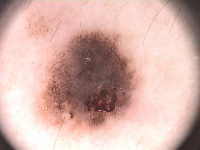</td><td>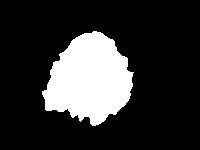</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
! wget https://www.dropbox.com/s/t0ichx42vg218hc/PH2Dataset.rar

--2021-05-31 16:16:26--  https://www.dropbox.com/s/t0ichx42vg218hc/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/t0ichx42vg218hc/PH2Dataset.rar [following]
--2021-05-31 16:16:26--  https://www.dropbox.com/s/raw/t0ichx42vg218hc/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc025e967a7e5dc6e4d245bd9f6d.dl.dropboxusercontent.com/cd/0/inline/BPhqQNJzMECj2M3lcnJxoTPk87Xk17oegv-Tog7QY5jxTsmNJE9iip94u8zoUj490SzQgWWtPpCbARClT-pj6p2D3_-gT2tQAJFgDerWFs51Z47x3eYn-N1vtV92vU4Ahlp9EdbhRBXtap-p7jKRQqGH/file# [following]
--2021-05-31 16:16:26--  https://uc025e967a7e5dc6e4d245bd9f6d.dl.dropboxusercontent.com/cd/0/inline/BPhqQNJzMECj2M3lcnJxoTPk87Xk17oegv-Tog7QY5jxTsmNJE9iip94u8zoUj490SzQgWWtPpCbARClT-pj

In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):

  # Функция walk() модуля os принимает один обязательный аргумент - имя каталога.
  # Возвращает объект-генератор, из которого получают кортежи для КАЖДОГО каталога переданной файловой иерархии, 
  # т.е. любой вложенности
  # Каждый кортеж состоит из трех элементов:
  # Адрес очередного каталога в виде строки - root - # PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image
  # В форме списка имена подкаталогов первого уровня вложенности для данного каталога -dirs - []
  # В виде списка имена файлов данного каталога - files - # ['IMD002.bpm']

    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)

X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions] 
# Изначально таргет-картинки - матрицы с 0 и 255, при уменьшении размера - с 0 и числами <1,
# сравнение с 0.5 создает бинарную маску с true/false

# mode='constant' - точки за пределами ввода заполняются согласно заданному режиму. Режимы соответствуют поведению numpy.pad
# anti_aliasing=True - следует ли применять фильтр Гаусса для сглаживания изображения перед уменьшением масштаба. 
# При понижающей дискретизации изображения крайне важно фильтровать, чтобы избежать артефактов наложения спектров.

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

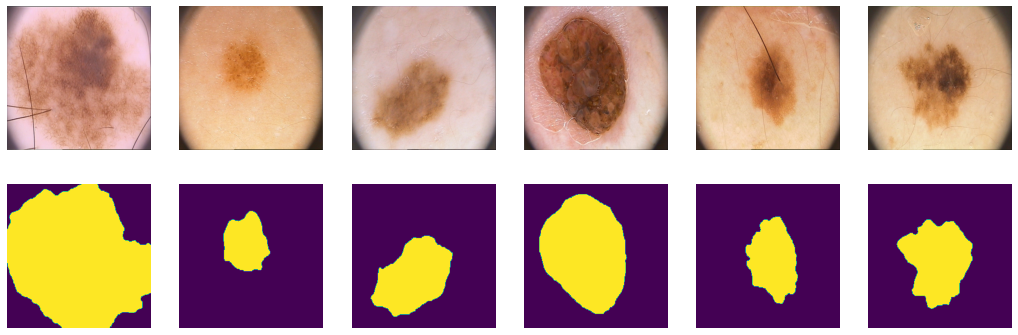

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
ix = np.random.choice(len(X), len(X), False) # генерим массив размера len(X) из чисел range(len(X)), replace=False, т.е. случайные индексы
tr, val, ts = np.split(ix, [100, 150]) # 100, 150 - индексы массива ix, по которым проходит разделение

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
X[tr].shape

(100, 256, 256, 3)

In [ ]:
np.rollaxis(X[tr], 3, 1).shape # прокручивает заданную ось (3), пока она не окажется в заданной позиции (1)

(100, 3, 256, 256)

In [ ]:
Y[tr].shape

(100, 256, 256)

In [ ]:
Y[tr, np.newaxis].shape # вставляем новую ось после оси tr

(100, 1, 256, 256)

In [9]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
import random

In [13]:
SEED = 1983

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

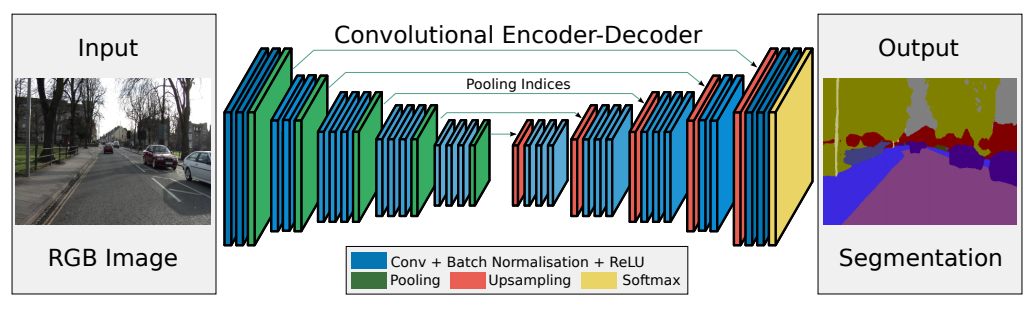

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [14]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [15]:
# см. https://www.youtube.com/watch?v=OWK8VlgJM4I&list=PL0Ks75aof3ThkitsZbUOEQg7Ybl5kB_s3&index=22&ab_channel=DeepLearningSchoolDeepLearningSchool с 37 минуты
# см. https://github.com/say4n/pytorch-segnet/blob/master/src/model.py

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )

        self.enc_conv0_0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.enc_conv0_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128


        self.enc_conv1_0 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )
        self.enc_conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64


        self.enc_conv2_0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )
        self.enc_conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32


        self.enc_conv3_0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512)
        )
        self.enc_conv3_1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16


        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512)
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 16 -> 8


        # bottleneck
        # self.bottleneck_conv = 

        # decoder (upsampling)

        self.upsample4 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 8 -> 16
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512)
        )

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv3_0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )
        self.dec_conv3_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv2_0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )
        self.dec_conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv1_0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.dec_conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )

        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)# 128 -> 256
        self.dec_conv0_0 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.dec_conv0_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        # encoder
        e0, indices_0 = self.pool0(F.relu(self.enc_conv0_1(F.relu(self.enc_conv0_0(x))))) # 256 -> 128
        e1, indices_1 = self.pool1(F.relu(self.enc_conv1_1(F.relu(self.enc_conv1_0(e0))))) # 128 -> 64
        e2, indices_2 = self.pool2(F.relu(self.enc_conv2_1(F.relu(self.enc_conv2_1(F.relu(self.enc_conv2_0(e1))))))) # 64 -> 32
        e3, indices_3 = self.pool3(F.relu(self.enc_conv3_1(F.relu(self.enc_conv3_1(F.relu(self.enc_conv3_0(e2))))))) # 32 -> 16
        e4, indices_4 = self.pool4(F.relu(self.enc_conv4(F.relu(self.enc_conv4(F.relu(self.enc_conv4(e3))))))) # 16 -> 8

        # # bottleneck
        # b = 

        # decoder
        d4 = F.relu(self.dec_conv4(F.relu(self.dec_conv4(F.relu(self.dec_conv4(self.upsample4(e4, indices_4)))))))
        d3 = F.relu(self.dec_conv3_1(F.relu(self.dec_conv3_1(F.relu(self.dec_conv3_0(self.upsample3(d4, indices_3)))))))
        d2 = F.relu(self.dec_conv2_1(F.relu(self.dec_conv2_1(F.relu(self.dec_conv2_0(self.upsample2(d3, indices_2)))))))
        d1 = F.relu(self.dec_conv1_1(F.relu(self.dec_conv1_0(self.upsample1(d2, indices_1)))))
        d0 = self.dec_conv0_1(F.relu(self.dec_conv0_0(self.upsample0(d1, indices_0))))    # no activation
        return d0

In [ ]:
# !pip install torchinfo
# from torchinfo import summary 

# model = SegNet()

# summary(model)

In [16]:
!nvidia-smi 

Mon May 31 16:17:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [17]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2)) # Will be zero if both are 0 
    union = (outputs | labels).float().sum((1, 2))        # Will be zero if Truth=0 or Prediction=0 
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    # torch.clamp(20 * (iou - 0.5), 0, 10) - обрезать значения 20 * (iou - 0.5) по отрезку [0, 10], .ceil() - округление в большую сторону
    # An Intersection over Union score > 0.5 is normally considered a “good” prediction - https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [18]:
def bce_loss(y_pred, y_real, eps=1e-3):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch

    return torch.mean(torch.clamp(y_pred, 0) - y_pred * y_real + torch.log(1 + torch.exp(-abs(y_pred))))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [19]:
def train(model, opt, loss_fn, epochs, scheduler, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss_tr = 0
        avg_loss_val = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_pred, Y_batch)# forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss_tr += loss / len(data_tr)
        toc = time()
        print('loss_tr: %f' % avg_loss_tr)
        scheduler.step()

        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad(): # detach 
            for X_batch, Y_batch in data_val:
                Y_hat = model(X_batch.to(device))
                loss =  loss_fn(Y_hat, Y_batch.to(device))
                avg_loss_val += loss / len(data_val)

        print('loss_val: %f' % avg_loss_val)

        # Visualize tools
        clear_output(wait=True)

        Y_hat = predict(model, X_val).cpu()

        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            # plt.imshow(np.rollaxis(X_batch[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss_tr: %f, loss_val: %f' % (epoch+1, epochs, avg_loss_tr, avg_loss_val))
        plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [20]:
def predict(model, data):
    model.eval()  # testing mode
    # X_pred = [X_batch for X_batch, _ in data]

    with torch.no_grad(): # detach 
          Y_pred = model(data.to(device))
          Y_pred = torch.sigmoid(Y_pred) 
          Y_pred = Y_pred > 0.5

    return Y_pred
    # return np.array(Y_pred)

In [21]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = predict(model, X_batch)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [22]:
# кроме разных архитектур и метрик будем сравнивать и начальный lr

lr_3=1e-3
lr_4=1e-4

# SegNet + bce

### 1. lr_3

In [23]:
segnet_model_bce_3 = SegNet().to(device)

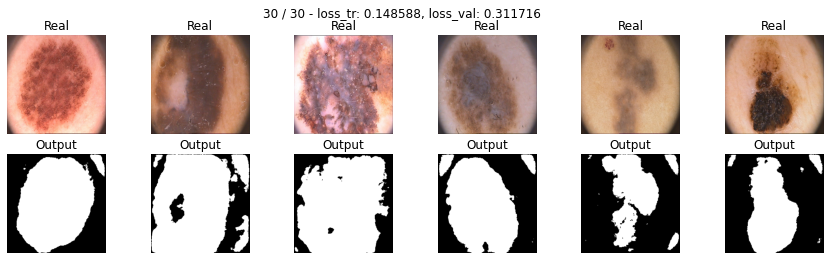

In [24]:
max_epochs = 30
opt = optim.Adam(segnet_model_bce_3.parameters(), lr_3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 5, 0.5)
train(segnet_model_bce_3, opt, bce_loss, max_epochs, scheduler, data_tr, data_val)

In [25]:
segnet_bce_score_3 = score_model(segnet_model_bce_3, iou_pytorch, data_val)
segnet_bce_score_3

0.48999999463558197

### 2. lr_4

In [26]:
segnet_model_bce_4 = SegNet().to(device)

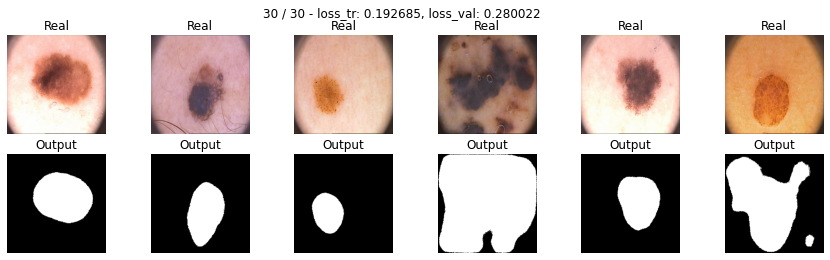

In [27]:
max_epochs = 30
opt = optim.Adam(segnet_model_bce_4.parameters(), lr_4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 5, 0.5)
train(segnet_model_bce_4, opt, bce_loss, max_epochs, scheduler, data_tr, data_val)

In [28]:
segnet_bce_score_4 = score_model(segnet_model_bce_4, iou_pytorch, data_val)
segnet_bce_score_4

0.656000018119812

Вывод: для SegNet + bce lr_4 выигрывает

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [29]:
def dice_loss(y_pred, y_real, eps=1e-3):
    y_pred = torch.sigmoid(y_pred) 
    numerator = 2 * (y_pred * y_real).sum()
    denominator = (y_pred + y_real).sum()
    res = 1 - ((numerator + eps) / (denominator + eps)) / 65536
    return res

Проводим тестирование:

# SegNet + dice

### 1. lr_3

In [31]:
segnet_model_dice_3 = SegNet().to(device)

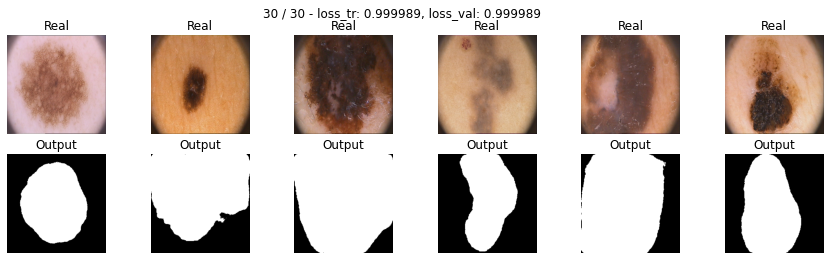

In [32]:
max_epochs = 30
opt = optim.Adam(segnet_model_dice_3.parameters(),  lr_3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 5, 0.5)
train(segnet_model_dice_3, opt, dice_loss, max_epochs, scheduler, data_tr, data_val)

In [33]:
segnet_dice_score_3 = score_model(segnet_model_dice_3, iou_pytorch, data_val)
segnet_dice_score_3

0.44200000166893005

### 2. lr_4

In [34]:
segnet_model_dice_4 = SegNet().to(device)

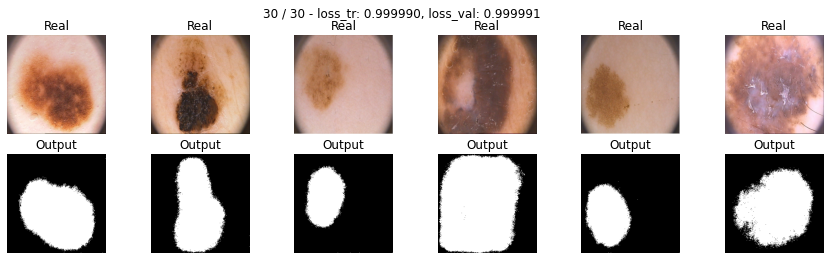

In [35]:
max_epochs = 30
opt = optim.Adam(segnet_model_dice_4.parameters(),  lr_4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 5, 0.5)
train(segnet_model_dice_4, opt, dice_loss, max_epochs, scheduler, data_tr, data_val)

In [36]:
segnet_dice_score_4 = score_model(segnet_model_dice_4, iou_pytorch, data_val)
segnet_dice_score_4

0.535999983549118

Вывод: для SegNet + dice выигрывает lr_4

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, который взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [37]:
def focal_loss(y_pred, y_real, eps = 1e-4, gamma = 2):
    y_pred = torch.clamp(torch.sigmoid(y_pred), eps)
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    your_loss = -(((1-y_pred)**gamma) * y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred))
    return your_loss.mean()

# SegNet + focal

### 1. lr_3

In [38]:
segnet_model_focal_3 = SegNet().to(device)

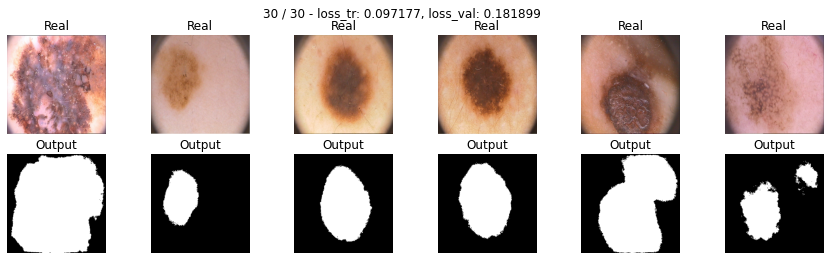

In [39]:
max_epochs = 30
opt = optim.Adam(segnet_model_focal_3.parameters(), lr_3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 5, 0.5)
train(segnet_model_focal_3, opt, focal_loss, max_epochs, scheduler, data_tr, data_val)

In [40]:
segnet_focal_score_3 = score_model(segnet_model_focal_3, iou_pytorch, data_val)
segnet_focal_score_3

0.5960000157356262

### 2. lr_4

In [41]:
segnet_model_focal_4 = SegNet().to(device)

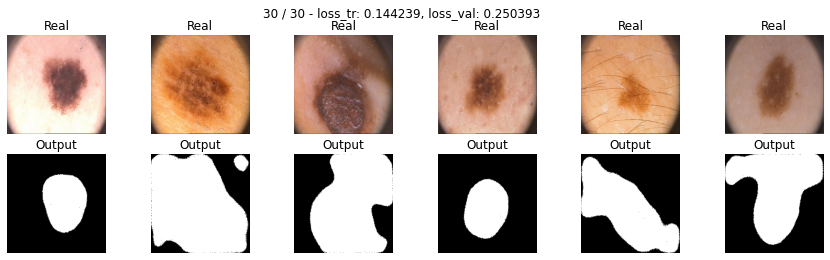

In [42]:
max_epochs = 30
opt = optim.Adam(segnet_model_focal_4.parameters(), lr_4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 5, 0.5)
train(segnet_model_focal_4, opt, focal_loss, max_epochs, scheduler, data_tr, data_val)

In [43]:
segnet_focal_score_4 = score_model(segnet_model_focal_4, iou_pytorch, data_val)
segnet_focal_score_4

0.5620000064373016

Вывод: для SegNet + focal выигрывает lr_3

### Сводная таблица для модели Segnet

In [44]:
import pandas as pd

In [49]:
segnet_table = pd.DataFrame.from_dict(data={'SegNet + bce':[segnet_bce_score_3, segnet_bce_score_4],
                'SegNet + dice':[segnet_dice_score_3, segnet_dice_score_4], 
                'SegNet + focal':[segnet_focal_score_3, segnet_focal_score_4]}, orient='index', columns = ['lr_3', 'lr_4'])
segnet_table

,lr_3,lr_4
SegNet + bce,0.490,0.656
SegNet + dice,0.442,0.536
SegNet + focal,0.596,0.562


### Общие выводы для Segnet:
1. Лучший результат модель Segnet получает с лоссом bce и lr=1e-4 - это 0.656
2. С лоссами bce и dice меньший начальный шаг обучения дает более точную модель, но с лоссом focal получается наоборот - выигрывает больший начальный шаг обучения
3. Хуже всего работает модель с лоссом dice 
4. Результат модели с лоссом focal не сильно отличается в зависимости от величины начального шага обучения - всего на 0.034
5.  Для модели с лоссом bce выбор lr играет большое значение - разница в результате - 0.166

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

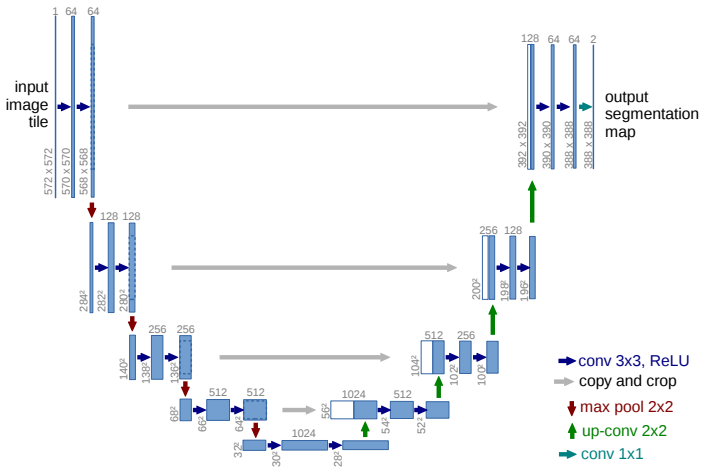

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [50]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )

        self.enc_conv0_0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.enc_conv0_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2) # 256 -> 128


        self.enc_conv1_0 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )
        self.enc_conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64


        self.enc_conv2_0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )
        self.enc_conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32


        self.enc_conv3_0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512)
        )
        self.enc_conv3_1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv_0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024)
        )
        self.bottleneck_conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024)
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0_0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512)
        )
        self.dec_conv0_1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512)
        )

        self.upsample1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1_0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )
        self.dec_conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )

        self.upsample2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2_0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )
        self.dec_conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )

        self.upsample3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3_0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.dec_conv3_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.dec_conv3_2 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)


    def forward(self, x):
        # encoder
        e0_0 = F.relu(self.enc_conv0_1(F.relu(self.enc_conv0_0(x))))
        e0_1 = self.pool0(e0_0) # 256 -> 128
        e1_0 = F.relu(self.enc_conv1_1(F.relu(self.enc_conv1_0(e0_1))))
        e1_1 = self.pool1(e1_0) # 128 -> 64
        e2_0 = F.relu(self.enc_conv2_1(F.relu(self.enc_conv2_0(e1_1))))
        e2_1 = self.pool2(e2_0) # 64 -> 32
        e3_0 = F.relu(self.enc_conv3_1(F.relu(self.enc_conv3_0(e2_1))))
        e3_1 = self.pool3(e3_0) # 32 -> 16

        # bottleneck
        b = F.relu(self.bottleneck_conv_1(F.relu(self.bottleneck_conv_0(e3_1))))

        # decoder
        d0 = F.relu(self.dec_conv0_1(F.relu(self.dec_conv0_0(torch.cat((e3_0, self.upsample0(b)), dim=1)))))
        d1 = F.relu(self.dec_conv1_1(F.relu(self.dec_conv1_0(torch.cat((e2_0, self.upsample1(d0)), dim=1)))))
        d2 = F.relu(self.dec_conv2_1(F.relu(self.dec_conv2_0(torch.cat((e1_0, self.upsample2(d1)), dim=1)))))
        d3 = self.dec_conv3_2(F.relu(self.dec_conv3_1(F.relu(self.dec_conv3_0(torch.cat((e0_0, self.upsample3(d2)), dim=1))))))  # no activation
        return d3

# Unet + bce

### 1. lr_3

In [51]:
unet_model_bce_3 = UNet().to(device)

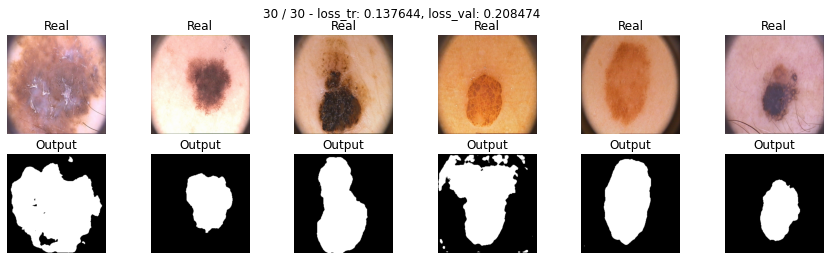

In [52]:
max_epochs = 30
opt = optim.Adam(unet_model_bce_3.parameters(), lr_3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 5, 0.5)
train(unet_model_bce_3, opt, bce_loss, max_epochs, scheduler, data_tr, data_val)

In [53]:
unet_bce_score_3 = score_model(unet_model_bce_3, iou_pytorch, data_val)
unet_bce_score_3

0.7359999716281891

### 2. lr_4

In [54]:
unet_model_bce_4 = UNet().to(device)

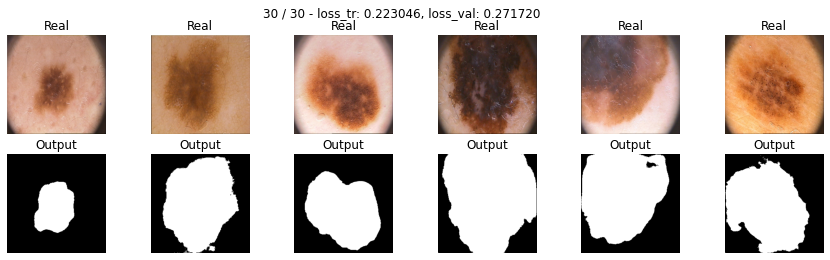

In [55]:
max_epochs = 30
opt = optim.Adam(unet_model_bce_4.parameters(), lr_4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 5, 0.5)
train(unet_model_bce_4, opt, bce_loss, max_epochs, scheduler, data_tr, data_val)

In [56]:
unet_bce_score_4 = score_model(unet_model_bce_4, iou_pytorch, data_val)
unet_bce_score_4

0.7360000014305115

Вывод: для Unet + bce оба lr дают примерно одинаковый результат

### Сравнение Segnet и Unet по лоссу bce

In [62]:
bce_table = pd.DataFrame.from_dict(data={'SegNet + bce':[segnet_bce_score_3, segnet_bce_score_4],
                'Unet + bce':[unet_bce_score_3, unet_bce_score_4]}, orient='index', columns = ['lr_3', 'lr_4'])
bce_table

,lr_3,lr_4
SegNet + bce,0.490,0.656
Unet + bce,0.736,0.736


### Выводы для лосса bce:
1. С сетью Unet лосс bce работает лучше, чем с Segnet, как минимум на 0.08
2. Для сети Segnet с лоссом bce выбор начального lr между 1e-3 и 1e-4 важен, а для Unet - нет

In [66]:
# torch.cuda.empty_cache() 

# Unet + dice

### 1. lr_3

In [57]:
unet_model_dice_3 = UNet().to(device)

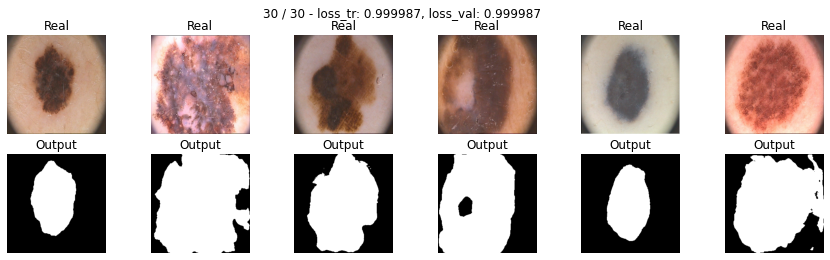

In [58]:
max_epochs = 30
opt = optim.Adam(unet_model_dice_3.parameters(), lr_3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 5, 0.5)
train(unet_model_dice_3, opt, dice_loss, max_epochs, scheduler, data_tr, data_val)

In [59]:
unet_dice_score_3 = score_model(unet_model_dice_3, iou_pytorch, data_val)
unet_dice_score_3

0.6880000233650208

### 2. lr_4

In [64]:
unet_model_dice_4 = UNet().to(device)

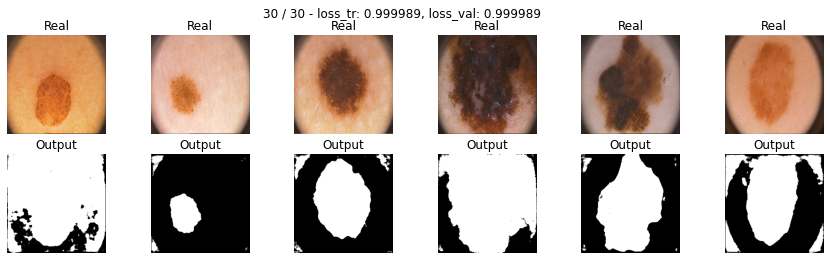

In [65]:
max_epochs = 30
opt = optim.Adam(unet_model_dice_4.parameters(), lr_4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 5, 0.5)
train(unet_model_dice_4, opt, dice_loss, max_epochs, scheduler, data_tr, data_val)

In [66]:
unet_dice_score_4 = score_model(unet_model_dice_4, iou_pytorch, data_val)
unet_dice_score_4

0.5119999796152115

Вывод: для Unet + dice выигрывает lr_3

### Сравнение Segnet и Unet по лоссу dice

In [67]:
dice_table = pd.DataFrame.from_dict(data={'SegNet + dice':[segnet_dice_score_3, segnet_dice_score_4],
                'Unet + dice':[unet_dice_score_3, unet_dice_score_4]}, orient='index', columns = ['lr_3', 'lr_4'])
dice_table

,lr_3,lr_4
SegNet + dice,0.442,0.536
Unet + dice,0.688,0.512


### Выводы для лосса dice:
1. Лосс dice по-разному ведет себя с разными сетями и lr: для Segnet выгоднее lr_4, для Unet выгоднее lr_3
2. Наилучший результат лосс dice показывает с сетью Unet и lr_3  - 0.688. Этот результат больше лучшего результата Segnet с тем же лоссом на 0.152

# Unet + focal

### 1. lr_3

In [68]:
unet_model_focal_3 = UNet().to(device)

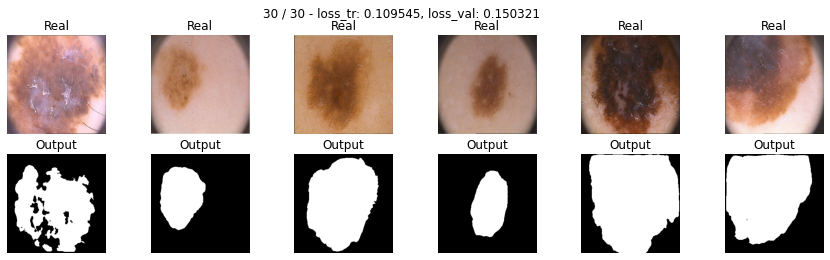

In [69]:
max_epochs = 30
opt = optim.Adam(unet_model_focal_3.parameters(), lr_3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 5, 0.5)
train(unet_model_focal_3, opt, focal_loss, max_epochs, scheduler, data_tr, data_val)

In [70]:
unet_focal_score_3 = score_model(unet_model_focal_3, iou_pytorch, data_val)
unet_focal_score_3

0.7060000002384186

### 2. lr_4

In [71]:
unet_model_focal_4 = UNet().to(device)

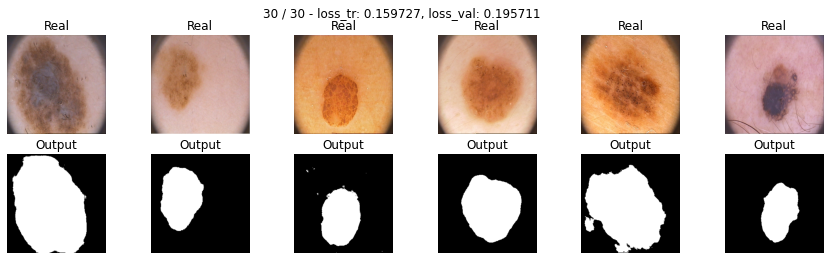

In [72]:
max_epochs = 30
opt = optim.Adam(unet_model_focal_4.parameters(), lr_4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 5, 0.5)
train(unet_model_focal_4, opt, focal_loss, max_epochs, scheduler, data_tr, data_val)

In [73]:
unet_focal_score_4 = score_model(unet_model_focal_4, iou_pytorch, data_val)
unet_focal_score_4

0.7540000081062317

Вывод: для Unet + focal выигрывает lr_4

### Сравнение Segnet и Unet по лоссу focal

In [74]:
focal_table = pd.DataFrame.from_dict(data={'SegNet + focal':[segnet_focal_score_3, segnet_focal_score_4],
                'Unet + focal':[unet_focal_score_3, unet_focal_score_4]}, orient='index', columns = ['lr_3', 'lr_4'])
focal_table

,lr_3,lr_4
SegNet + focal,0.596,0.562
Unet + focal,0.706,0.754


### Выводы для лосса focal:
1. Лосс focal, также как и лосс dice, по-разному ведет себя с разными сетями и lr: для Segnet выгоднее lr_3, для Unet выгоднее lr_4
2. Наилучший результат лосс focal показывает с сетью Unet и lr_4  - 0.754. Этот результат больше лучшего результата Segnet с тем же лоссом на 0.158

### Сводная таблица для модели Unet

In [75]:
unet_table = pd.DataFrame.from_dict(data={'Unet + bce':[unet_bce_score_3, unet_bce_score_4],
                'Unet + dice':[unet_dice_score_3, unet_dice_score_4], 
                'Unet + focal':[unet_focal_score_3, unet_focal_score_4]}, orient='index', columns = ['lr_3', 'lr_4'])
unet_table

,lr_3,lr_4
Unet + bce,0.736,0.736
Unet + dice,0.688,0.512
Unet + focal,0.706,0.754


### Общие выводы для Unet:
1. Лучший результат модель Unet получает с лоссом focal и lr=1e-4 - это 0.754. 
2. Для лосса bce выбор начального шага обучения между lr_3 и lr_4 не принципиален, для лосса dice больший начальный шаг обучения дает более точную модель, а с лоссом focal получается наоборот - выигрывает меньший начальный шаг обучения
3. Как и в случае Segnet, хуже всего Unet работает с лоссом dice
4. Для модели с лоссом dice выбор lr играет значение - разница в результате - 0.176
5. Результат модели с лоссом focal не сильно отличается в зависимости от величины начального шага обучения - на 0.048
6. В целом, почти с любым лоссом модель Unet работает лучше, чем Segnet c аналогичным лоссом, за исключением случая лосса dice + lr_4

### Рейтинг всех моделей

In [79]:
score_dict = {'SegNet_bce_3': segnet_bce_score_3, 'SegNet_bce_4': segnet_bce_score_4,
              'SegNet_dice_3': segnet_dice_score_3, 'SegNet_dice_4': segnet_dice_score_4, 
              'SegNet_focal_3': segnet_focal_score_3, 'SegNet_focal_4': segnet_focal_score_4,
              'Unet_bce_3': unet_bce_score_3, 'Unet_bce_4': unet_bce_score_4,
              'Unet_dice_3': unet_dice_score_3, 'Unet_dice_4': unet_dice_score_4, 
              'Unet_focal_3': unet_focal_score_3, 'Unet_focal_4': unet_focal_score_4}

In [89]:
score_list_sort = [(k, v) for k, v in sorted(score_dict.items(), key=lambda item: item[1], reverse=True)]
score_table = pd.DataFrame(score_list_sort, columns=['Model', 'Score'])

In [90]:
score_table

,Model,Score
0,Unet_focal_4,0.754
1,Unet_bce_4,0.736
2,Unet_bce_3,0.736
3,Unet_focal_3,0.706
4,Unet_dice_3,0.688
5,SegNet_bce_4,0.656
6,SegNet_focal_3,0.596
7,SegNet_focal_4,0.562
8,SegNet_dice_4,0.536
9,Unet_dice_4,0.512


### И итоговый результат лучших 5 моделей на тестовых данных

In [91]:
test_score_dict = {'Unet_focal_4': score_model(unet_model_focal_4, iou_pytorch, data_ts), 
                   'Unet_focal_3': score_model(unet_model_focal_3, iou_pytorch, data_ts), 
                   'Unet_bce_3': score_model(unet_model_bce_3, iou_pytorch, data_ts), 
                   'Unet_bce_4':score_model(unet_model_bce_4, iou_pytorch, data_ts), 
                   'Unet_dice_3': score_model(unet_model_dice_3, iou_pytorch, data_ts)}

In [92]:
test_score_list_sort = [(k, v) for k, v in sorted(test_score_dict.items(), key=lambda item: item[1], reverse=True)]
test_score_table = pd.DataFrame(test_score_list_sort, columns=['Model', 'Test_score'])
test_score_table

,Model,Test_score
0,Unet_bce_4,0.662
1,Unet_bce_3,0.654
2,Unet_focal_4,0.650
3,Unet_focal_3,0.608
4,Unet_dice_3,0.596


Интересно, что на тестовых данных лучше всего показала себя совсем не та модель, которая лидировала на валидационной выборке - unet_model_focal_4, а следующая за ней - unet_model_bce_4, скор - 0.662. При этом unet_model_focal_4 опустилась на третье место, скор 0.65, а на втором оказалась третья модель по рейтингу на валидационной выборке - unet_model_bce_3, скор 0.654. Таким образом, по тестовой выборке победил Unet, это не сюрприз, а вот метрика-лидер изменилась и стала bce. 

# Отчет (6 баллов)
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.

Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.